In [75]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing and Cleaning

In [76]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        if filepath.exists():  # Check if the file exists before opening it
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                os.remove(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                os.remove(filepath)
        else:
            print(f"{filepath} does not exist.")

hair_types\Straight_Hair\graphicstock-young-handsome-asiatic-long-brown-straight-hair-woman-taking-selfie-outdoor-in-the-city-with-a-smartphone-smiling-vanity-technology-social-network-concept_B6fyU2Ok-_SB_PM.jpg does not exist.
hair_types\Straight_Hair\graphicstock-young-handsome-caucasian-reddish-straight-hair-woman-sitting-on-a-small-wall-holding-a-tablet-taking-a-selfie-doing-grimace-technology-social-network-youthful-concept_BTFpe2_1W_SB_PM.jpg does not exist.


# Data Loading and Splitting

1ADDED: test_ds

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


In [78]:
class_names = train_ds.class_names

# Count the number of samples per class in the training set
for class_name in class_names:
    num_samples = len([filename for filename in train_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the training set: {num_samples}")

# Count the number of samples per class in the validation set
for class_name in class_names:
    num_samples = len([filename for filename in val_ds.file_paths if class_name in filename])
    print(f"Number of {class_name} samples in the validation set: {num_samples}")

Number of Curly_Hair samples in the training set: 276
Number of Straight_Hair samples in the training set: 250
Number of Wavy_Hair samples in the training set: 259
Number of Curly_Hair samples in the validation set: 56
Number of Straight_Hair samples in the validation set: 68
Number of Wavy_Hair samples in the validation set: 72


# Mixed Precision Training and Data Prefetching

1ADDED: Mixed Precision Training -  speed up training without sacrificing much in terms of accuracy

In [79]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

1ADDED: Use the prefetch transformation to overlap the preprocessing and model execution of training.

In [80]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Visualization of Training Data

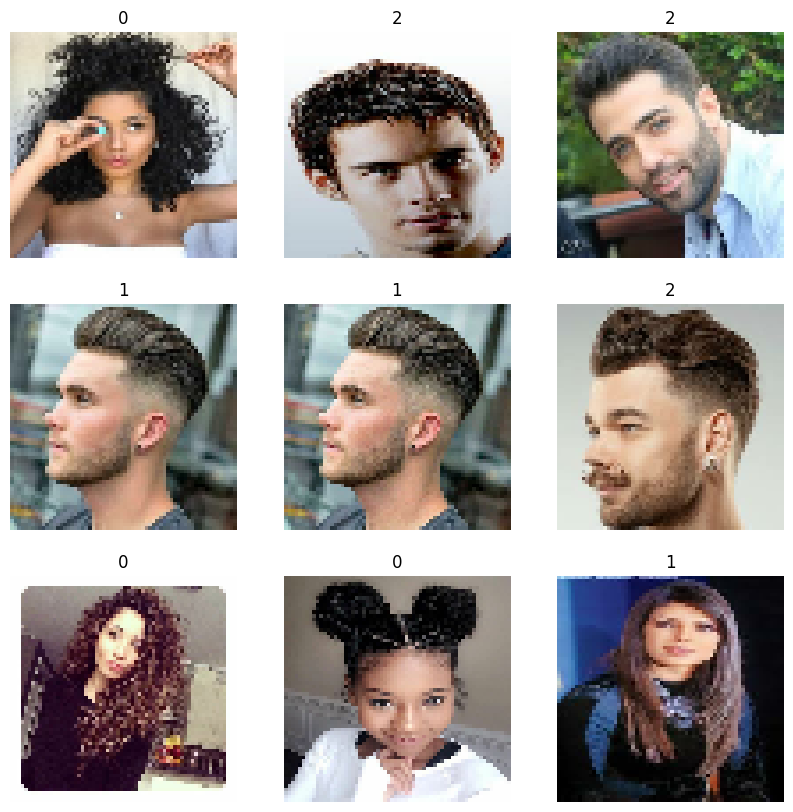

In [81]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

# Model Architecture

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=2))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=2))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=2))
model.add(layers.Activation("relu"))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

# Visualizing Model Architecture

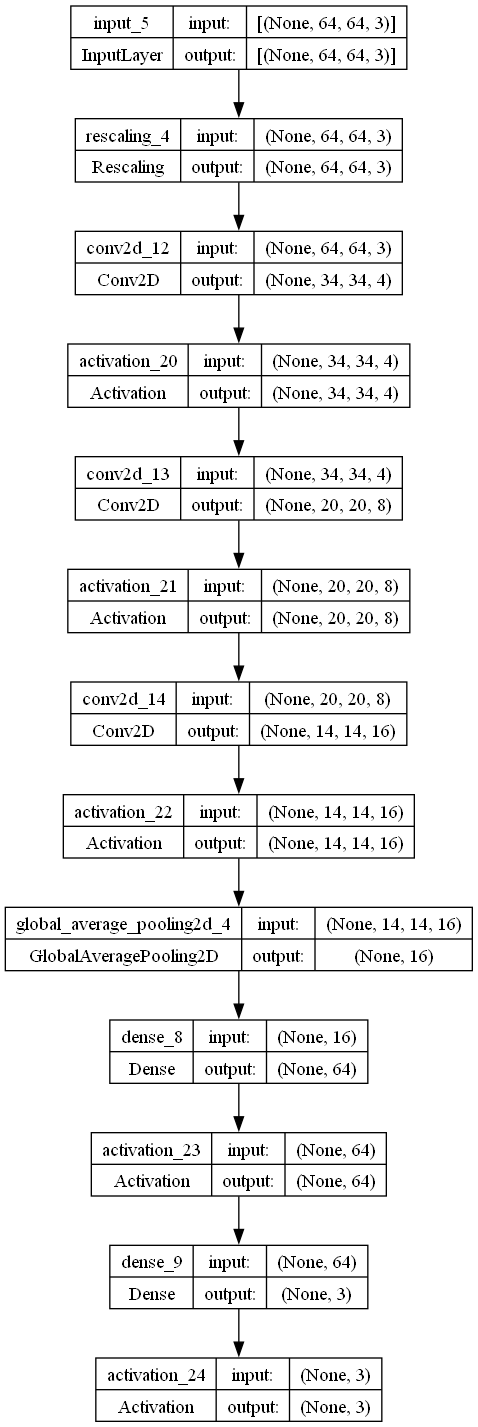

In [83]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

# Display Model Summary

In [84]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 4)         3076      
                                                                 
 activation_20 (Activation)  (None, 34, 34, 4)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 8)         2056      
                                                                 
 activation_21 (Activation)  (None, 20, 20, 8)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 activation_22 (Activation)  (None, 14, 14, 16)       

# Model Training

In [85]:
epochs = 30

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()],
)

# Training the Model

In [86]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/30


25/25 [==============================] - 61s 2s/step - loss: 1.0992 - accuracy: 0.3567 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - auc_6: 0.5112 - val_loss: 1.1008 - val_accuracy: 0.2857 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_auc_6: 0.4681
Epoch 2/30
25/25 [==============================] - 72s 3s/step - loss: 1.0971 - accuracy: 0.3516 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - auc_6: 0.5212 - val_loss: 1.1028 - val_accuracy: 0.2857 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_auc_6: 0.4869
Epoch 3/30
25/25 [==============================] - 64s 3s/step - loss: 1.0880 - accuracy: 0.3516 - precision_6: 0.6154 - recall_6: 0.0102 - auc_6: 0.5474 - val_loss: 1.0940 - val_accuracy: 0.2857 - val_precision_6: 0.4000 - val_recall_6: 0.0204 - val_auc_6: 0.4871
Epoch 4/30
25/25 [==============================] - 71s 3s/step - loss: 1.0635 - accuracy: 0.4446 - precision_6: 0.6000 - recall_6: 0.0688 - auc_6: 0.6231 - val_loss: 1.0883 - val_a

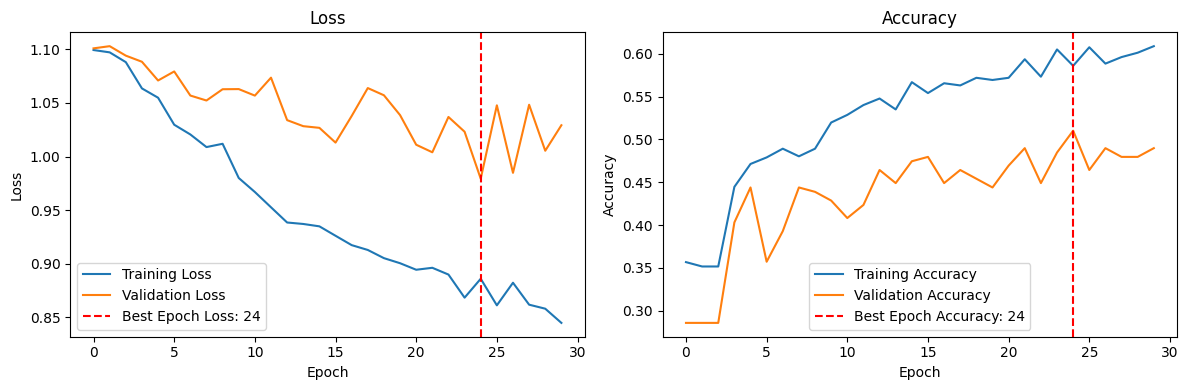

In [87]:
import matplotlib.pyplot as plt

# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Mark the best epoch for validation loss
best_epoch_loss = np.argmin(history.history['val_loss'])
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label=f'Best Epoch Loss: {best_epoch_loss}')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Mark the best epoch for validation accuracy
best_epoch_accuracy = np.argmax(history.history['val_accuracy'])
plt.axvline(x=best_epoch_accuracy, color='r', linestyle='--', label=f'Best Epoch Accuracy: {best_epoch_accuracy}')
plt.legend()

plt.tight_layout()
plt.show()


In [88]:
# Print the best epochs
print(f'Best Epoch for Validation Loss: {best_epoch_loss}')
print(f'Best Epoch for Validation Accuracy: {best_epoch_accuracy}')

Best Epoch for Validation Loss: 24
Best Epoch for Validation Accuracy: 24


# Model Testing and Evaluation

In [89]:
# Load and test an image of curly hair
img_curly = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array_curly = keras.preprocessing.image.img_to_array(img_curly)
img_array_curly = tf.expand_dims(img_array_curly, 0)  # Create batch axis

predictions_curly = model.predict(img_array_curly)
print(
    "CURLY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_curly[0])
)

# Load and test an image of straight hair
img_straight = keras.preprocessing.image.load_img(
    "hair_types/Straight_Hair/1-short-spiky-mens-haircut.jpg", target_size=image_size
)
img_array_straight = keras.preprocessing.image.img_to_array(img_straight)
img_array_straight = tf.expand_dims(img_array_straight, 0)  # Create batch axis

predictions_straight = model.predict(img_array_straight)
print(
    "STRAIGHT: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_straight[0])
)

# Load and test an image of wavy hair
img_wavy = keras.preprocessing.image.load_img(
    "hair_types/Wavy_Hair/2-Short-High-Volume-Hairstyle.jpg", target_size=image_size
)
img_array_wavy = keras.preprocessing.image.img_to_array(img_wavy)
img_array_wavy = tf.expand_dims(img_array_wavy, 0)  # Create batch axis

predictions_wavy = model.predict(img_array_wavy)
print(
    "WAVY: This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions_wavy[0])
)

1/1 [==============================] - 0s 250ms/step
CURLY: This image is 0.78 percent curly hair, 0.11 percent straight hair, and 0.11 percent wavy hair.
1/1 [==============================] - 0s 37ms/step
STRAIGHT: This image is 0.00 percent curly hair, 0.76 percent straight hair, and 0.24 percent wavy hair.
1/1 [==============================] - 0s 44ms/step
WAVY: This image is 0.38 percent curly hair, 0.08 percent straight hair, and 0.54 percent wavy hair.


1ADDED: give you insights into how well your model generalizes to new, unseen data based on your validation dataset

AUC = 0.5: The model performs no better than random chance.

AUC < 0.5: The model performs worse than random chance.

AUC > 0.5: The model has some discriminatory power, with higher values indicating better discrimination.

In [90]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")

7/7 [==============================] - 1s 97ms/step - loss: 1.0289 - accuracy: 0.4898 - precision_6: 0.5163 - recall_6: 0.4031 - auc_6: 0.6835
Validation Loss: 1.0289381742477417
Validation Accuracy: 0.4897959232330322
Validation Precision: 0.516339898109436
Validation Recall: 0.4030612111091614
Validation AUC: 0.6834782361984253


In [106]:
val_images = []
val_labels = []

for (images, labels) in val_ds.take(3):  # Assuming your dataset does not include filenames
    val_images.append(images)
    val_labels.append(labels)

# Concatenate the batches to get the images and labels
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

# Test the model on the selected validation images
predictions = model.predict(val_images)

for i in range(len(val_images)):
    print(f"Image {i + 1}")
    print(f"True Label: {val_labels[i]}")
    print(f"Predictions: {predictions[i]}")
    print()


3/3 [==============================] - 0s 63ms/step
Image 1
True Label: [0. 0. 1.]
Predictions: [0.01492 0.518   0.4663 ]

Image 2
True Label: [0. 1. 0.]
Predictions: [0.01129 0.521   0.4678 ]

Image 3
True Label: [0. 1. 0.]
Predictions: [0.4802 0.234  0.2852]

Image 4
True Label: [0. 1. 0.]
Predictions: [0.8027  0.117   0.08057]

Image 5
True Label: [1. 0. 0.]
Predictions: [0.5356 0.2283 0.2366]

Image 6
True Label: [1. 0. 0.]
Predictions: [0.8804  0.1041  0.01576]

Image 7
True Label: [0. 0. 1.]
Predictions: [0.086  0.4104 0.5034]

Image 8
True Label: [1. 0. 0.]
Predictions: [0.639  0.1626 0.1981]

Image 9
True Label: [1. 0. 0.]
Predictions: [0.626  0.1438 0.2303]

Image 10
True Label: [0. 1. 0.]
Predictions: [0.7373  0.1608  0.10254]

Image 11
True Label: [0. 0. 1.]
Predictions: [0.08966 0.1243  0.7866 ]

Image 12
True Label: [0. 1. 0.]
Predictions: [0.4731 0.2625 0.2644]

Image 13
True Label: [0. 1. 0.]
Predictions: [0.04913 0.2443  0.7065 ]

Image 14
True Label: [1. 0. 0.]
Predict